In [1]:
import torch
import difflib
import re
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import difflib
import numpy as np

from model.ResNetSR import ResNetSR
from model.utils import get_device, restore_full_page
from data_utils.downsample import pdf_to_image, downsample_by_factors 

# Test Notebook
This notebook tests the model's restoration performance on downsampled pdf images.

## 0. Configuration
To do a test run on a pdf file,
1. Configure the following information 
2. Put the pdf file you want to test in *test/test_pdfs/*
3. Run the rest of the notebook to produce results

In [2]:
# Configure this to specify the pdf & page number

page_num = 0 # Change this to the page number you want to test on
downsample_factors = [4]
pdf_dir = "test/test_pdfs/Chinese Simplified PDF.pdf" # Change this to the path of the PDF you want to use
pdf_language = "chi_sim"
plt.rcParams['font.sans-serif'] = ['Hei'] # Uncomment this to show Chinese characters in plots
ckpt_path = "saved_models/resnetsr/resolution128-512/ckpt_0"

## 1. Load Model

In [3]:
device = get_device()
ckpt = torch.load(ckpt_path, map_location=torch.device('cpu'))
history = ckpt["history"]

model = ResNetSR(upscale_factor=4, num_res_blocks=6, num_channels=1, num_features=32)
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

ResNetSR(
  (entry): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32

## Load pdf & test model's denoising performance

In [4]:
img_dir = f"test/test_images".format(page_num)
downampled_dir = f"test/downsampled_images/downsampled".format(page_num)
recovered_dir = "test/recovered_images".format(page_num)

pdf_to_image(pdf_dir, page_num, img_dir)
downsample_by_factors(img_dir, downampled_dir, downsample_factors)

Downsampling by factors complete!


In [5]:
downsampled_dir = "test/downsampled_images"
restore_full_page(page_num, downsampled_dir, model, device)

## 3. Test the model's restoration performance based on efficiency of text extraction
This section evaluates the model's performance based on 2 text extraction metrics:
1. **Character Similarity**: The relative frequency of similar consecutive characters in the original vs downsampled / restored images. This is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.
2. **Word recall**: Number of common words in both original vs downsampled / restored images divided by the total number of words in the original document. This is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.

In [6]:
def read_text_with_tesseract(image_path, lang):
    """Extract text from an image using Tesseract OCR"""
    try:
        img = Image.open(image_path)
        text = pytesseract.image_to_string(img, lang = lang)
        return text
    except Exception as e:
        return f"Error processing {image_path}: {str(e)}"

def compare_texts(text1, text2):
    """Compare two texts and return similarity to reference text"""
    # Clean texts for comparison
    clean1 = clean_text(text1)
    clean2 = clean_text(text2)
    
    # Calculate character-level similarity ratio
    char_similarity = difflib.SequenceMatcher(None, clean1, clean2).ratio() * 100 # Return a measure of the sequences’ similarity as a float in the range [0, 1]. Where T is the total number of elements in both sequences, and M is the number of matches, this is 2.0*M / T. Note that this is 1.0 if the sequences are identical, and 0.0 if they have nothing in common.
    
    # Word similarity
    words1 = set(clean1.split())
    words2 = set(clean2.split())
    common_words = words1.intersection(words2)
    total_words = len(words1)
    
    if total_words:
        word_recall = (len(common_words) / total_words) * 100
    else:
        word_recall = 0
    
    return {
        "character_similarity": char_similarity,
        "word_recall": word_recall
    }

def clean_text(text):
    """Clean up text for better comparison"""
    text = re.sub(r'\s+', ' ', text).strip().lower()
    text = re.sub(r'[.,;:!?()\[\]{}"\'-]', '', text)
    return text

def visualize_comparison(original_path, downsampled_path, restored_path, lang='eng'):
    # Load images
    original_img = np.array(Image.open(original_path))
    downsampled_img = np.array(Image.open(downsampled_path))
    restored_img = np.array(Image.open(restored_path))
    
    # Extract text
    original_text = read_text_with_tesseract(original_path, lang = lang)
    downsampled_text = read_text_with_tesseract(downsampled_path, lang = lang)
    restored_text = read_text_with_tesseract(restored_path, lang = lang)

    # Calculate metrics
    downsampled_metrics = compare_texts(original_text, downsampled_text)
    restored_metrics = compare_texts(original_text, restored_text)
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Display images
    axes[0, 0].imshow(original_img, cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(downsampled_img, cmap='gray')
    axes[0, 1].set_title('Downsampled')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(restored_img, cmap='gray')
    axes[0, 2].set_title('Restored')
    axes[0, 2].axis('off')
    
    # Display text and metrics
    text_props = dict(fontsize=8, ha='left', va='top', wrap=False)
    metrics_props = dict(fontsize=9, ha='center', va='center')
    
    # Format text samples (first 300 chars)
    orig_sample = original_text[:300] + '...' if len(original_text) > 300 else original_text
    down_sample = downsampled_text[:300] + '...' if len(downsampled_text) > 300 else downsampled_text
    rest_sample = restored_text[:300] + '...' if len(restored_text) > 300 else restored_text
    
    axes[1, 0].text(0.05, 0.95, orig_sample, **text_props)
    axes[1, 0].axis('off')
    
    axes[1, 1].text(0.05, 0.95, down_sample, **text_props)
    axes[1, 1].text(0.5, 0.2, f"Character similarity: {downsampled_metrics['character_similarity']:.1f}%" + '\n' + f"Word recall: {downsampled_metrics['word_recall']:.1f}%", **metrics_props)
    axes[1, 1].axis('off')
    
    axes[1, 2].text(0.05, 0.95, rest_sample, **text_props)
    axes[1, 2].text(0.5, 0.2, f"Character similarity: {restored_metrics['character_similarity']:.1f}%" + '\n' + f"Word recall: {restored_metrics['word_recall']:.1f}%", **metrics_props)
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('comparison_results.png', dpi=1000)
    plt.show()
    
    # Print improvement summary
    char_improvement = restored_metrics['character_similarity'] - downsampled_metrics['character_similarity']
    word_improvement = restored_metrics['word_recall'] - downsampled_metrics['word_recall']
    
    print(f"Restoration improvement:")
    print(f"Character similarity: +{char_improvement:.1f}%")
    print(f"Word recall: +{word_improvement:.1f}%")

    return original_text, downsampled_text, restored_text, downsampled_metrics, restored_metrics

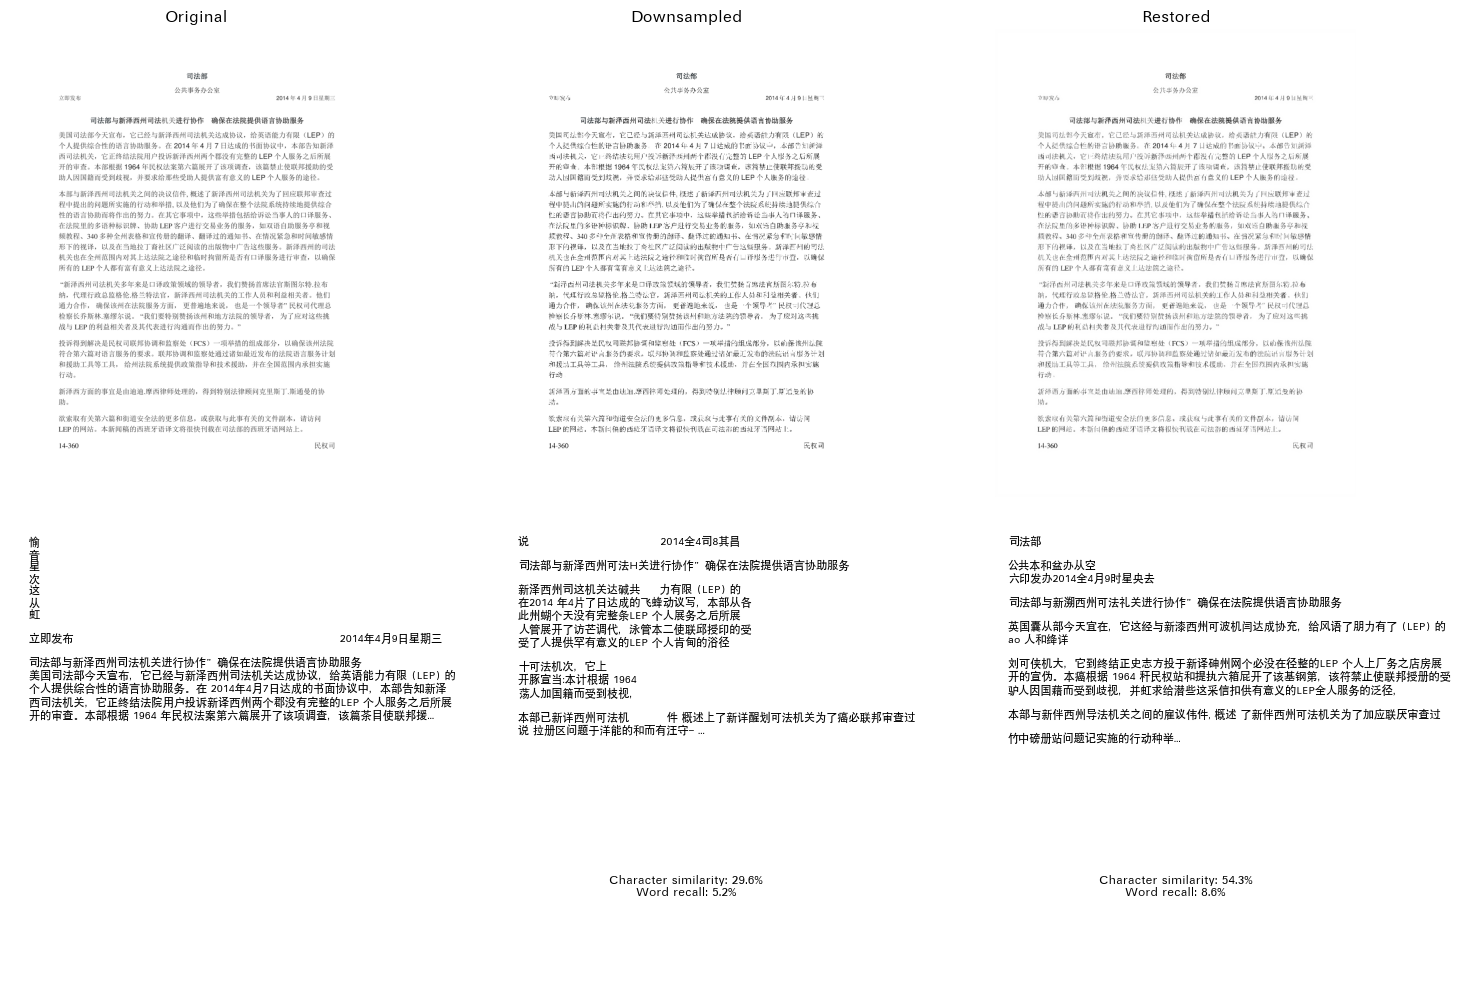

Restoration improvement:
Character similarity: +24.8%
Word recall: +3.4%


In [8]:
# Example usage
original_text, downsampled_text, restored_text, downsampled_metrics, restored_metrics = visualize_comparison(
    original_path=f"test/test_images/page_{page_num}.png",
    downsampled_path=f"test/downsampled_images/downsampled_4x/page_{page_num}.png",
    restored_path=f"test/downsampled_images/restoration_4x/page_{page_num}.png", 
    lang = pdf_language
)

In [9]:
original_text

'愉\n音\n星\n次\n这\n从\n虹\n\n立即发布                                                                       2014年4月9日星期三\n\n司法部与新泽西州司法机关进行协作”确保在法院提供语言协助服务\n美国司法部今天宣布，它已经与新泽西州司法机关达成协议，给英语能力有限 (LEP) 的\n个人提供综合性的语言协助服务。在 2014年4月7日达成的书面协议中，本部告知新泽\n西司法机关，它正终结法院用户投诉新译西州两个郡没有完整的LEP 个人服务之后所展\n开的审查。本部根据 1964 年民权法案第六篇展开了该项调查，该篇茶目使联邦援助的受\n助人因国籍而受到歧视，并要求给那些受助人提供富有意义的LEP 个人服务的途径。\n\n本部与新泽西州司法机关之间的决议信件, 概述了新译西州司法机关为了回应联邦审查过\n程中提出的问题所实施的行动和举措, 以及他们为了确保在整个法院系统持续地提供综合\n性的语言协助而将作出的努力。在其它事项中，这些举措包括给诉讼当事人的口译服务、\n在法院里的多语种标识牌、协助 LEP 客户进行交易业务的服务，如双语自助服务部和视\n频教程、340 多种全州表格和宣传册的翻译、翻译过的通知书、在情况紧急和时间敏感情\n形下的视译，以及在当地拉丁裔社区广泛阅读的出版物中广告这些服务。新泽西州的司法\n机关也在全州范围内对其上达法院之途径和临时拘留所是否有口译服务进行审查，以确保\n所有的 LEP个人都有富有意义上达法院之途径。\n\n“新泽西州司法机关多年来是口译政策领域的领导者，我们赞扬首席法官斯图尔特.拉布\n纳，代理行政总监格伦.格兰特法官，新泽西州司法机关的工作人员和利益相关者。他们\n通力合作， 确保该州在法院服务方面， 更普授地来说， 也是一个领导者”民权司代理总\n检察长乔斯林.塞赦尔说。 “我们要特别赞扬该州和地方法院的领导者， 为了应对这些挑\n战与 LEP 的利益相关者及其代表进行沟通而作出的努力。”\n\n投诉得到解决是民权司联邦协调和监察处 (FCS) 一项举措的组成部分，以确保该州法院\n符合第六篇对语言服务的要求。联邦协调和监察处通过诸如最近发布的法院语言服务计划\n和援助工具等工具，给州法院系统提供政策指导和技术援助，并在全国

In [10]:
downsampled_text

'说                                   2014全4司8其昌\n\n司法部与新泽西州可法H关进行协作”确保在法院提供语言协助服务\n\n新泽西州司这机关达碱共     力有限 (LEP) 的\n在2014 年4片了日达成的飞蜂动议写，本部从各\n此州蝴个天没有完整条LEP 个人展务之后所展\n人管展开了访芒调代，泳管本二使联邱授印的受\n受了人提供罕有意义的LEP 个人肯甸的浴径\n\n十可法机次，它上\n开豚宣当:本计根据 1964\n荡人加国籍而受到枝视，\n\n本部已新详西州可法机          件 概述上了新详醒划可法机关为了癌必联邦审查过\n说 拉册区问题于洋能的和而有汪守- 忆必他们为了王代全整个法|   盱污浊提供信\n\n力。在其它于项中，这些举措条\n牌、协晤 LEP 客户进行变易\n\n球人航口译服务\n;白助报务学各讽\n名和中答情\n务，困洋瑟划的司法\n进行刷在，以确保\n\n训导也企全川范计风\n语有的LEP 个人导育守\n\n新泽占州本法机关光年米是口主攻    寅导埋，和护作英扬革蜂法官其国外特技\n代惠行政总永格从,将          的工作大剖和天管相关者，往们\n通方合作， 确代i                也是“个领导上”民权-代理总\n\n检许长丰民宁.可    科村特别橡押刻州和志方法沉交领导者，为了\n战与LE隐私益村关郑和其人于行光过而作出癌惫\n\n4拓\n\n没诉每到解决是民骏司圈\n全第六篇上让让求务四夺\n\n莉分，以而保该\n\n总由违浊,章西乱证处理的，得到污别\n\n敏表点有关第六篇寞街道安全|\nIEP 的网           的轴址\n\n.360\n'

In [11]:
restored_text

'司法部\n\n公共本和盆办从空\n六印发办2014全4月9时星央去\n\n司法部与新溯西州可法礼关进行协作”确保在法院提供语言协助服务\n\n英国囊从部今天宜在，它这经与新漆西州可波机闫达成协充，给风语了朋力有了 (LEP) 的\nao 人和绛详\n\n刘可侠机大，它到终结正史志方投于新译砷州网个必没在径整的LEP 个人上厂务之店房展\n开的宣伪。本癌根据 1964 秆民权站和提执六箱屁开了该基钢第，该符禁止使联邦授册的受\n驴人因国藉而受到歧视，并虹求给潜些这采信扣供有意义的LEP全人服务的泛径，\n\n本部与新伴西州导法机关之间的雇议伟件, 概述 了新伴西州可法机关为了加应联厌审查过\n\n竹中磅册站问题记实施的行动种举请 以及他们方了确你在整个流耽， ne\n\n位的语言苏助看妊作出的努力，在其它束融中，这些从措外括给诉讼当彤人汐口译服务，\n\n在法隐患网党证种标训用，队助 LEP 各户进行殉易业务的上服务，如双语自助节务尝和乌\n\n烽教程、340 光卉企玫家格帮罕传册的册译、知译这的通知书、 在和合况里入和让全敏感情\n形下内视诺，以及在当地核丁攻社区广沁陪庶的出版物中广告这些服务，新漳西州的司站\n机关记在全州范扎座胡其 上 ee 途季和上蜂中提几所且省在呈译贱务进行市杰，以太估\n万有的 LEP 个人必育贡育闪义三达锯院立放答。\n\n:守[经讽州可续机关光年米是口译政策领码的领导者，我们贫扬口店法官舱图尔特扫布\n多，氏二行政怠雄格伦,格基贬冰官，新泽西州可法机闫的工作入员和利益相关者 他们\n通力合作， 确傣访州住污总最务方而， 更芝通中有米襄， 也是 个领导省”民权司代型总\n扮膏长介靳林,变继估说。 “我们要和震别委扬仿州和地方块跤的领导音，为了应对这妊朱\n战与LEP 的乱堆村基老及其代表训行汐通而作出内努力。”\n\n投 ee ee   和 加 鉴放处 (FECS)  we   ee  以信保该州达院\n的   sn   :指导和和传术模肌   并在全国共图内承担怀施\n行动，\n\n新汲西方面的河宣是由选迪,辟西律荐处坦的，得到符别沙律硕问元蛙所本起秆朗的下\n勘。\n\n欠壳局有尖第六御刊街道密生法鹏囊甸信息。或大色与此事在关的文件副本，语访河\nLEP 的网和站。本条全稿的四址牙语译文将祖居刊允在本法癌的四古语网和站上。\n\n1